In [1]:
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

## AlphaLens

In [3]:
performance = pd.read_pickle('single_factor.pickle')

In [4]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.items()],axis=1).T
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]
prices.index = prices.index.normalize()
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Columns: 1649 entries, A to ZTS
dtypes: float64(1649)
memory usage: 9.5 MB


In [5]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.head()

date                       asset
2015-01-02 00:00:00+00:00  A        2618.0
                           AAL      1088.0
                           AAP       791.0
                           AAPL     2917.0
                           ABBV     2952.0
dtype: float64

In [6]:
with pd.HDFStore('../00_data/assets.h5') as store:
    sp500 = store['sp500/prices'].close
sp500 = sp500.resample('D').ffill().tz_localize('utc').filter(prices.index.get_level_values(0))
sp500.head()

date
2015-01-02 00:00:00+00:00    2058.20
2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
2015-01-08 00:00:00+00:00    2062.14
Name: close, dtype: float64

In [7]:
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=(1, 5, 10, 30),
                                                      quantiles=5)

Dropped 11.5% entries from factor data: 11.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


### Summary Tear Sheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1067.0,302.725013,189.155150,133697,20.043686
2,337.0,1691.0,847.414998,241.040902,133268,19.979371
3,774.0,2235.0,1403.632790,270.908118,133248,19.976373
4,1252.0,2633.0,1967.452989,262.768177,133268,19.979371
5,1800.0,3056.0,2509.875797,231.030919,133547,20.021199


Returns Analysis


,1D,5D,10D,30D
Ann. alpha,0.040,0.037,0.034,-0.000
beta,0.073,0.066,0.081,0.058
Mean Period Wise Return Top Quantile (bps),1.445,1.328,1.442,0.011
Mean Period Wise Return Bottom Quantile (bps),-3.001,-2.908,-2.406,-0.595
Mean Period Wise Spread (bps),4.445,4.232,3.852,0.612


Information Analysis


,1D,5D,10D,30D
IC Mean,0.021,0.020,0.025,0.008
IC Std.,0.142,0.142,0.129,0.121
Risk-Adjusted IC,0.145,0.144,0.195,0.064
t-stat(IC),NaN,3.878,5.245,1.721
p-value(IC),NaN,0.000,0.000,0.086
IC Skew,NaN,0.385,0.268,0.050
IC Kurtosis,NaN,0.042,-0.533,-0.447


Turnover Analysis


,10D,1D,30D,5D
Quantile 1 Mean Turnover,0.589,0.085,0.828,0.411
Quantile 2 Mean Turnover,0.738,0.134,0.806,0.644
Quantile 3 Mean Turnover,0.764,0.141,0.803,0.677
Quantile 4 Mean Turnover,0.737,0.134,0.804,0.641
Quantile 5 Mean Turnover,0.567,0.081,0.807,0.393


,1D,5D,10D,30D
Mean Factor Rank Autocorrelation,0.942,0.712,0.453,-0.014


<Figure size 432x288 with 0 Axes>

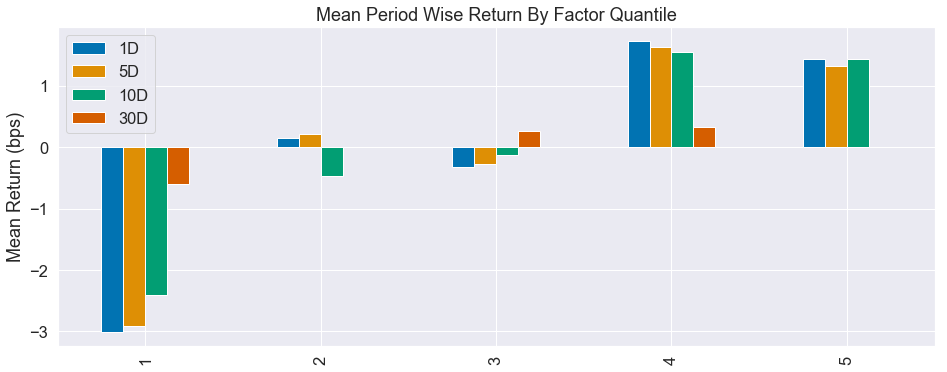

In [8]:
create_summary_tear_sheet(alphalens_data)

### Returns Analysis

In [9]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

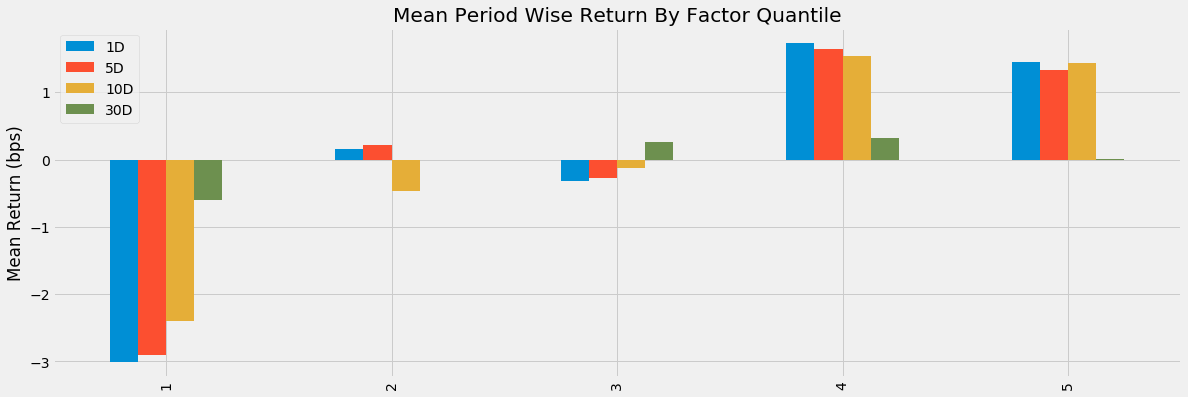

In [10]:
plot_quantile_returns_bar(mean_return_by_q_norm);

In [11]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

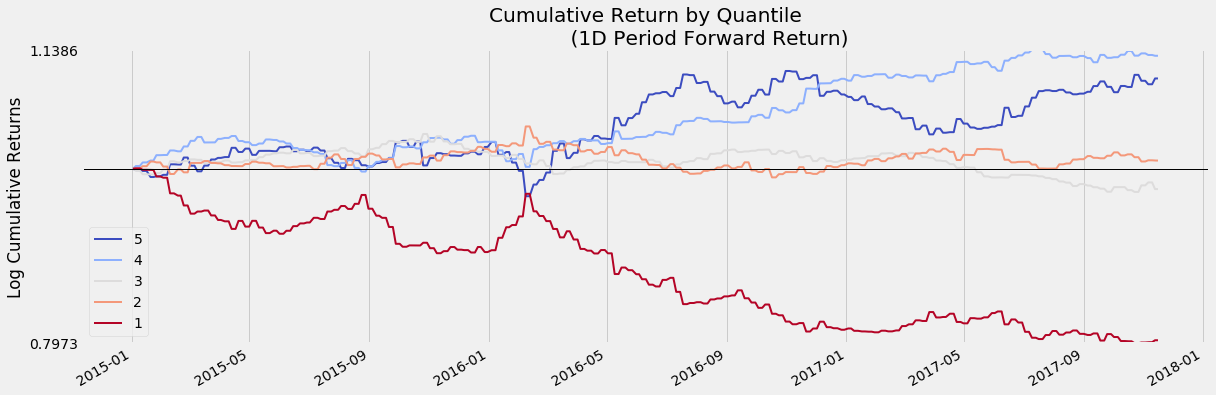

In [12]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['1D'], period='1D');